## 2.Equality Assessment

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load datasets
file_shp = 'MSOA_2011_London_gen_MHW.shp'
file_nighttime_stops = 'MSOA_nighttime_stops.csv'
file_msoa_data = 'msoa-data.csv'

In [3]:
# 加载Shapefile数据
msoa_boundary = gpd.read_file(file_shp)

In [4]:
# 计算每个MSOA区域的面积（平方千米）
msoa_boundary['area_sq_km'] = msoa_boundary.to_crs(epsg=27700).area / 1e6

In [5]:
# 加载夜间公交站点数据
nighttime_stops_df = pd.read_csv(file_nighttime_stops)

In [6]:
# 合并夜间站点数据与MSOA边界数据
merged_data = msoa_boundary.merge(nighttime_stops_df, left_on='MSOA11CD', right_on='MSOA11CD', how='left')
merged_data['NUMPOINTS'].fillna(0, inplace=True)  # 处理NaN值

In [7]:
# 计算每平方千米的站点密度
merged_data['stop_density_per_sq_km'] = merged_data['NUMPOINTS'] / merged_data['area_sq_km']


In [8]:
# 加载MSOA数据
msoa_data_df = pd.read_csv(file_msoa_data, encoding='ISO-8859-1')

In [9]:
# 计算人口密度
merged_data = merged_data.merge(msoa_data_df, left_on='MSOA11CD', right_on='Middle Super Output Area')
merged_data['population_density'] = merged_data['Age Structure (2011 Census);All Ages;'] / merged_data['area_sq_km']

In [10]:
# 准备用于洛伦兹曲线和基尼系数计算的数据
# 按站点密度排序
sorted_df = merged_data.sort_values(by='stop_density_per_sq_km')
sorted_df['cum_stops_density'] = np.cumsum(sorted_df['stop_density_per_sq_km']) / sorted_df['stop_density_per_sq_km'].sum()
sorted_df['cum_population_density'] = np.cumsum(sorted_df['population_density']) / sorted_df['population_density'].sum()

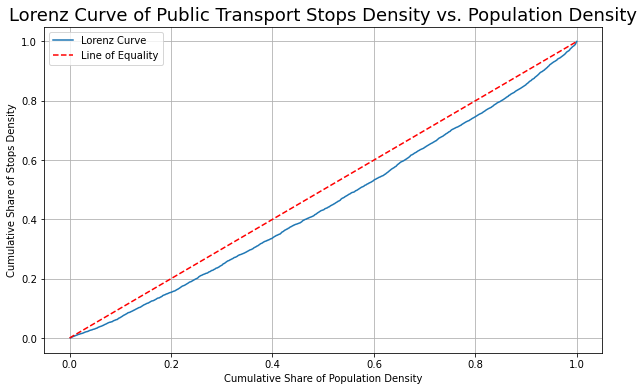

In [12]:
# 绘制洛伦兹曲线
plt.figure(figsize=(10, 6))
plt.plot(sorted_df['cum_population_density'], sorted_df['cum_stops_density'], label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Line of Equality')
plt.title('Lorenz Curve of Public Transport Stops Density vs. Population Density',fontsize=18)
plt.xlabel('Cumulative Share of Population Density')
plt.ylabel('Cumulative Share of Stops Density')
plt.legend()
plt.grid(True)

In [13]:
# 计算基尼系数
area_under_lorenz = np.trapz(sorted_df['cum_stops_density'], sorted_df['cum_population_density'])
gini_coefficient = 2 * (0.5 - area_under_lorenz)

print(gini_coefficient)

0.09750868666172696
